Code based on the actuarial data science tutorial and paper:
https://github.com/actuarial-data-science/Tutorials/tree/master/6%20-%20Lee%20and%20Carter%20go%20Machine%20Learning%20Recurrent%20Neural%20Networks

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

Data

 The data is divided by genders, and
 the raw mortality rates are denoted by mx, see line 7 of Listing 1. Since we are going to model
 log-mortality rates the raw morality rates need to be strictly positive. In the original data from
 the HMD there were 10 observations with mx = 0, these observations have been replaced
 by a mortality rate average over all available countries in the HMD (of the same age x, in the
 same calendar year t and of the same gender). These modi ed raw mortality rates received a
 flag, indicated on line 6 of Listing 1

In [67]:
mort_data_raw = pd.read_csv("CHE_mort.csv", sep=";")
mort_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13400 entries, 0 to 13399
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        13400 non-null  object 
 1   Year          13400 non-null  int64  
 2   Age           13400 non-null  int64  
 3   Country       13400 non-null  object 
 4   imputed_flag  13400 non-null  bool   
 5   mx            13400 non-null  float64
 6   logmx         13400 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 641.3+ KB


C:\Users\tomasz.skorkowski\AppData\Local\Temp\ipykernel_11888\451866668.py:3: FutureWarning: The provided callable <function mean at 0x000001A48FD1A8C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = data[data["Gender"] == gender].pivot_table(index="Age", columns="Year", values="logmx", aggfunc=np.mean)
C:\Users\tomasz.skorkowski\AppData\Local\Temp\ipykernel_11888\451866668.py:3: FutureWarning: The provided callable <function mean at 0x000001A48FD1A8C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = data[data["Gender"] == gender].pivot_table(index="Age", columns="Year", values="logmx", aggfunc=np.mean)


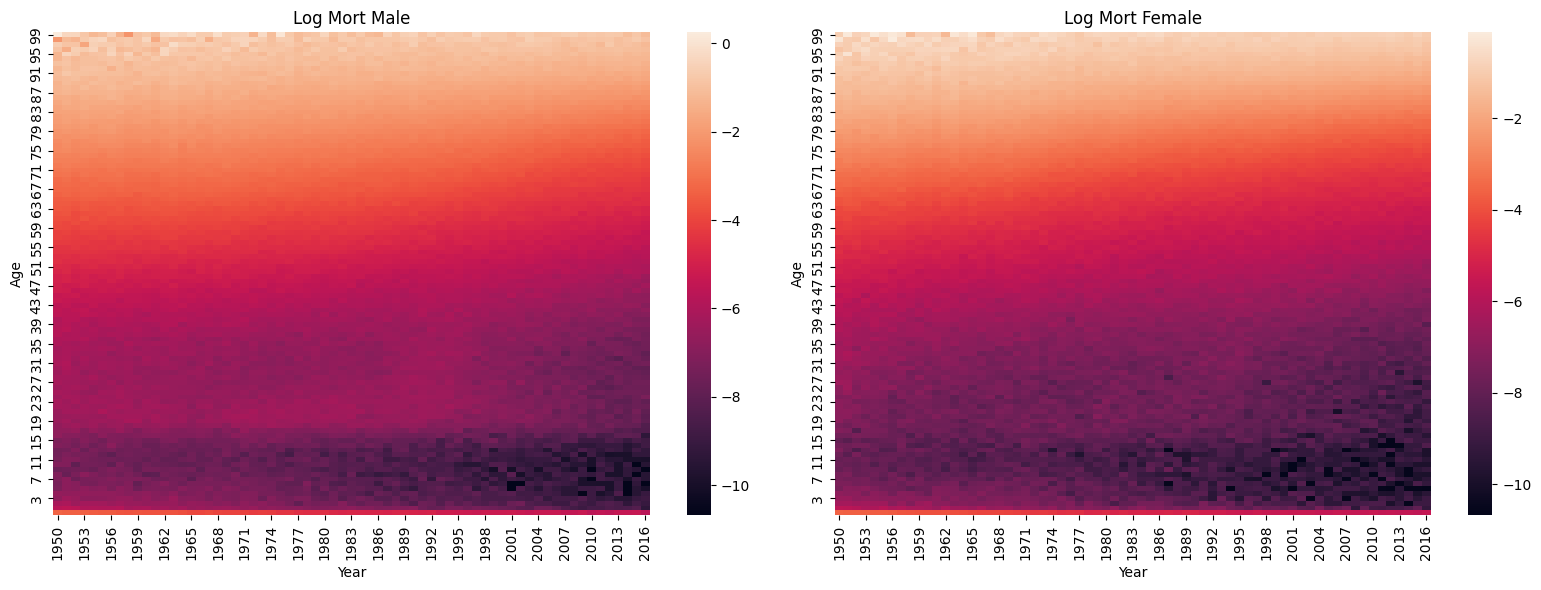

In [68]:
# Function to create heatmap data
def create_heatmap_data(data, gender):
    pivot = data[data["Gender"] == gender].pivot_table(index="Age", columns="Year", values="logmx", aggfunc=np.mean)
    return pivot.sort_index(level='Age', ascending=False)

# Create heatmap data for males and females
heatmap_data = {gender: create_heatmap_data(mort_data_raw, gender) for gender in ['Male', 'Female']}

# Create subplots
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

# Plot heatmaps
for ax, (gender, data) in zip(axs, heatmap_data.items()):
    sns.heatmap(data=data, ax=ax, cbar=True)
    ax.set_title(f"Log Mort {gender}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Age")

plt.tight_layout()
plt.show()

Lee-Carter for multi population

In [69]:
mort_data_raw.describe()

,Year,Age,mx,logmx
count,13400.000000,13400.000000,13400.000000,13400.000000
mean,1983.000000,49.500000,0.055859,-5.211013
std,19.339801,28.867147,0.112893,2.436790
min,1950.000000,0.000000,0.000023,-10.680016
25%,1966.000000,24.750000,0.000737,-7.212923
50%,1983.000000,49.500000,0.003710,-5.596723
75%,2000.000000,74.250000,0.041493,-3.182237
max,2016.000000,99.000000,1.285714,0.251314


In [70]:
# sample mortality rates
data = mort_data_raw.pivot(index=["Gender","Age"], columns="Year", values="logmx")

In [71]:
sample_size = 4
mort_sample = np.random.choice(data.columns,sample_size)
mort_gender = np.random.choice(["Female","Male"],sample_size)

plot_params = {"year": mort_sample,
               "symbol": ["--", "*", "o", "x"],
               "color": ['r','g','b','y'],
               "gender": mort_gender}



In [87]:
plot_params

{'year': array([1999, 2012, 2006, 1995], dtype=int64),
 'symbol': ['--', '*', 'o', 'x'],
 'color': ['r', 'g', 'b', 'y'],
 'gender': array(['Female', 'Male', 'Male', 'Male'], dtype='<U6')}

In [137]:
selected_series = data.loc[(mort_gender[0], slice(None)), mort_sample[0]]
selected_series.values.reshape(-1).shape

(100,)

In [140]:
def plot_mort_sample(year, symbol, color, gender):
    fig, ax = plt.subplots(figsize=(12,10))
    
    print(len(year))
    
    # Plot the series
    for i in range(len(year)):
        # Query the pivot table
        selected_series = data.loc[(gender[i], slice(None)), year[i]]
        label = f"{gender[i]}_{year[i]}"
        print(label)
        ax.plot(selected_series.index.get_level_values('Age'), selected_series, symbol[i], color[i], label=label)
    ax.set_title('Sample mortality rates')
    ax.set_xlabel('Year')
    ax.set_ylabel('Log Mort Rates')
    plt.legend( loc='upper left', numpoints = 1 )
    plt.show()

4
Female_1999
Male_2012
Male_2006
Male_1995


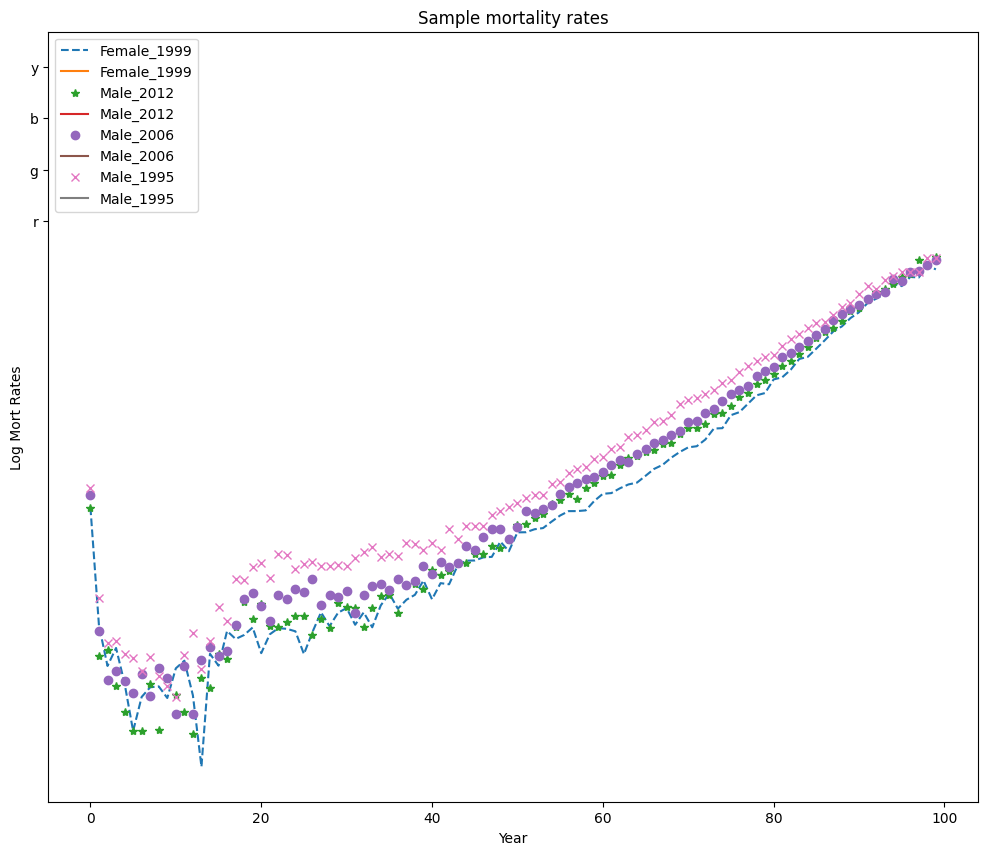

In [141]:
plot_mort_sample(**plot_params)

LSTM

In [5]:
from lstm import LstmModel

In [6]:
def LSTM_data_prep(tau0: int, T: int, data: pd.DataFrame, gender: str):
    # select gender
    data = data[data["Gender"] == gender]

    # Padding
    age_min, age_max = data["Age"].min(), data["Age"].max()
    year_min, year_max = data["Year"].min(), data["Year"].max()
    concat_data = []
    pad_len = (tau0-1)//2
    
    data_min_list = [
        data[(data["Age"] == age_min)].assign(Age=age_min - pad - 1)
        for pad in range(pad_len)
    ]
    data_max_list = [
        data[data["Age"] == age_max].assign(Age=age_max + pad + 1)
        for pad in range(pad_len)
    ]
        
    concat_data = pd.concat([data] + data_min_list + data_max_list, axis=0).reset_index(drop=True)
    pivot_concat_data = concat_data.pivot(index="Age", columns="Year", values="logmx")

    # Generate LSTM sequences
    x_train = np.array(
        [pivot_concat_data.loc[age - pad_len:age + pad_len, year - T:year-1]
        for year in range(year_min + T, year_max+1)
        for age in range(age_min, age_max + 1)
    ])
    Y_train = np.array(
        [pivot_concat_data.loc[age, year]
        for year in range(year_min + T, year_max+1)        
        for age in range(age_min, age_max + 1)
    ])
    
    return Variable(torch.Tensor(x_train).permute(0,2,1)), Variable(torch.Tensor(Y_train).unsqueeze(1))


In [7]:
# Data preprocessing

# Train-Test split
train_cutoff_year = 1999

mort_data_raw_train = mort_data_raw[(mort_data_raw["Year"] <= train_cutoff_year)]
mort_data_raw_test = mort_data_raw[(mort_data_raw["Year"] > train_cutoff_year)]

# Parameters
T = 10 # Look-back period, ie. sequence size from the manual implementation
tau0 = 5 # Number of neighbouring ages to smooth future values, odd inetger



In [8]:
x_train, Y_train = LSTM_data_prep(tau0,T,mort_data_raw_train, "Female")

In [9]:
x_train.size()

torch.Size([4000, 10, 5])

In [10]:
# Training
epochs = 500
learning_rate = 0.001

input_size = 5
hidden_size = 15
num_layers = 1
batch_size = 100
criterion = torch.nn.MSELoss()

lstm_models = {f"Lstm{layers}":LstmModel(hidden_sz=hidden_size, input_sz=input_size, num_layers=layers)
                for layers in range(1,4)}
lstm_optimisers = {f"optimizer{layers}":torch.optim.Adam(lstm_models[f"Lstm{layers}"].parameters(), lr=learning_rate)
                for layers in range(1,4)}

In [11]:
Y_train.size()

torch.Size([4000, 1])

In [16]:
model = lstm_models["Lstm3"]
optimizer = lstm_optimisers["optimizer3"]

for step in range(epochs):
    outputs = model(x_train)
    optimizer.zero_grad()
   
    loss = criterion(outputs, Y_train)
    loss.backward()

    optimizer.step()
    
    #if step % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (step, loss.item()))
else:
    print("Epoch: %d, loss: %1.5f" % (step, loss.item()))

Epoch: 0, loss: 31.95305
Epoch: 1, loss: 31.76331
Epoch: 2, loss: 31.56864
Epoch: 3, loss: 31.36860
Epoch: 4, loss: 31.16275
Epoch: 5, loss: 30.95069
Epoch: 6, loss: 30.73200
Epoch: 7, loss: 30.50633
Epoch: 8, loss: 30.27334
Epoch: 9, loss: 30.03279
Epoch: 10, loss: 29.78448
Epoch: 11, loss: 29.52833
Epoch: 12, loss: 29.26432
Epoch: 13, loss: 28.99261
Epoch: 14, loss: 28.71346
Epoch: 15, loss: 28.42727
Epoch: 16, loss: 28.13459
Epoch: 17, loss: 27.83606
Epoch: 18, loss: 27.53241
Epoch: 19, loss: 27.22446
Epoch: 20, loss: 26.91301
Epoch: 21, loss: 26.59887
Epoch: 22, loss: 26.28278
Epoch: 23, loss: 25.96542
Epoch: 24, loss: 25.64732
Epoch: 25, loss: 25.32892
Epoch: 26, loss: 25.01055
Epoch: 27, loss: 24.69241
Epoch: 28, loss: 24.37459
Epoch: 29, loss: 24.05712
Epoch: 30, loss: 23.73997
Epoch: 31, loss: 23.42304
Epoch: 32, loss: 23.10627
Epoch: 33, loss: 22.78955
Epoch: 34, loss: 22.47285
Epoch: 35, loss: 22.15616
Epoch: 36, loss: 21.83955
Epoch: 37, loss: 21.52314
Epoch: 38, loss: 21.20

KeyboardInterrupt: 

In [ ]:
# TODO: multilayer LSTM implementation in PyTorch
#       link between the layers
# TODO: batch learning

In [36]:
np.array(mort_data_raw.iloc[0:2,:])

array([['Female', 1950, 0, 'CHE', False, 0.027293, -3.60112501992636],
       ['Female', 1950, 1, 'CHE', False, 0.003046, -5.79392602450917]],
      dtype=object)

In [46]:
duplicate_groups = mort_data_raw.groupby(['Age', 'Year']).size().reset_index(name='count')
duplicates = duplicate_groups[duplicate_groups['count'] > 1]

print("\nDuplicate groups:")
print(duplicates)


Duplicate groups:
      Age  Year  count
0       0  1950      2
1       0  1951      2
2       0  1952      2
3       0  1953      2
4       0  1954      2
...   ...   ...    ...
6695   99  2012      2
6696   99  2013      2
6697   99  2014      2
6698   99  2015      2
6699   99  2016      2

[6700 rows x 3 columns]


In [47]:
mort_data_raw

,Gender,Year,Age,Country,imputed_flag,mx,logmx
0,Female,1950,0,CHE,False,0.027293,-3.601125
1,Female,1950,1,CHE,False,0.003046,-5.793926
2,Female,1950,2,CHE,False,0.001674,-6.392539
3,Female,1950,3,CHE,False,0.001234,-6.697494
4,Female,1950,4,CHE,False,0.001007,-6.900780
...,...,...,...,...,...,...,...
13395,Male,2016,95,CHE,False,0.299443,-1.205831
13396,Male,2016,96,CHE,False,0.332784,-1.100262
13397,Male,2016,97,CHE,False,0.312937,-1.161753
13398,Male,2016,98,CHE,False,0.392929,-0.934126
